### Simple clustering example using the package

In [1]:
import numpy as np
from matplotlib import pyplot as plt

Importing the package main class, and the Normal Inverse Wishart (NIW) prior.

Follow the installation guide at: https://github.com/BGU-CS-VIL/DPMMPython before importing. Extra steps are required after `pip install`.

In [2]:
from dpmmpython.dpmmwrapper import DPMMPython
from dpmmpython.priors import niw

In [20]:
import julia
from julia import Random
jl = julia.Julia()
jl.eval('Random.seed!(1)');

### Data Generation

We will use the package data generation function to generate some 2D data

In [4]:
D = 2 # Dimension
K = 20 # Number of Clusters
N = 20000 #Number of points
var_scale = 100.0 # The variance of the MV-Normal distribution where the clusters means are sampled from.
data, labels = DPMMPython.generate_gaussian_data(N, D, K, var_scale)

Plotting the data

Note that as Julia is a column first language, the data generated is $DxN$

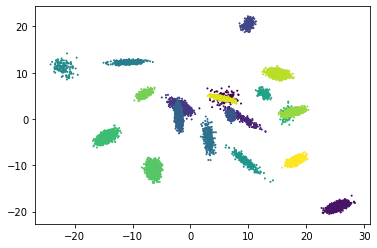

In [5]:
plt.scatter(data[0,:],data[1,:],c=labels, s=1)

### Fiting DPGMM Model to the data

Start by defining a niw prior and $\alpha$

In [6]:
prior = niw(1,np.zeros(D),2,np.eye(D)*0.5)
alpha = 10.0

Fit the model and store the results in `results`.
When working from Jupyter Notebook/Lab you will not see Julia prints. However when running python from terminal you will see all the prints (as in the Julia packages)

In [7]:
results = DPMMPython.fit(data,alpha,prior = prior,iterations=500, burnout=10)

The returned object is a tuple with  `(labels, cluster_distribution,sub_labels)`, we will only require the first item

In [8]:
inferred_labels = results[0]

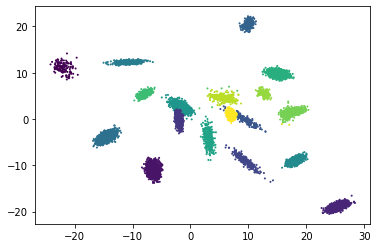

In [9]:
plt.scatter(data[0,:],data[1,:],c=inferred_labels, s=1)

Looks good, we can quantilize the quality of the clustering using NMI:

In [10]:
from sklearn.metrics.cluster import normalized_mutual_info_score

In [11]:
dpgmmm_nmi = normalized_mutual_info_score(inferred_labels.astype(int), np.array(labels),average_method='arithmetic')
print(f'DPGMM NMI:{dpgmmm_nmi}')                                          

DPGMM NMI:0.9728852990709327


### Comparing VS other methods

In [12]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

#### K-means:

In [13]:
kmeans = KMeans(n_clusters=K).fit(data.T)
kmeans_labels = kmeans.labels_

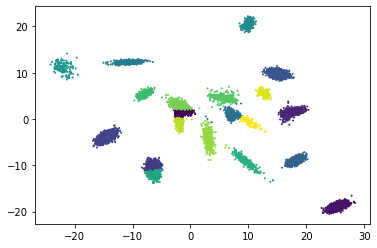

In [14]:
plt.scatter(data[0,:],data[1,:],c=kmeans_labels, s=1)

In [15]:
kmeans_nmi = normalized_mutual_info_score(kmeans_labels.astype(int), np.array(labels),average_method='arithmetic')
print(f'K-means NMI:{kmeans_nmi}')      

K-means NMI:0.9309229767796119


#### GMM:

In [16]:
gmm = GaussianMixture(n_components=20,covariance_type='full').fit(data.T)
gmm_labels = gmm.predict(data.T)

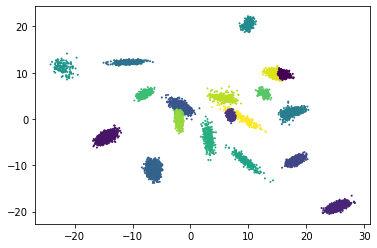

In [17]:
plt.scatter(data[0,:],data[1,:],c=gmm_labels, s=1)

In [18]:
gmm_nmi = normalized_mutual_info_score(gmm_labels.astype(int), np.array(labels),average_method='arithmetic')
print(f'GMM NMI:{gmm_nmi}')  

GMM NMI:0.9513343588873828


Even when using the correct K for K-means and GMM, the DPGMM outperform them.